In [1]:
import pymc3 as pm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import StandardScaler
import seaborn as sns
#import statsmodels.formula.api as smf
import statsmodels.api as smf

/home/rer/anaconda3/envs/pymc3_resources/lib/python3.7/site-packages/xarray/core/merge.py:17: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  PANDAS_TYPES = (pd.Series, pd.DataFrame, pd.Panel)


In [2]:
N = 2000 # num grant proposals
np.random.seed(seed=7)
p = 0.1 # proportion to select
# uncorrelated newsworthiness and trustworthiness
nw = stats.norm.rvs(loc=0, scale=1, size=N)
tw = stats.norm.rvs(loc=0, scale=1, size=N)

# select top 10% of combined scores
s = nw + tw # total score
q = np.quantile( s , 1-p ) # top 10% threshold

selected = s>= q
np.corrcoef(tw[selected], nw[selected])

array([[ 1.        , -0.76672285],
       [-0.76672285,  1.        ]])

In [3]:
N = 100
#np.random.seed(seed=7)
height = stats.norm.rvs(size=N, loc=10, scale=2)
leg_prop = stats.uniform.rvs(size=N, loc=0.4, scale=0.1)
leg_left = leg_prop * height + stats.norm.rvs(size=N, loc=0, scale=0.02)
leg_right = leg_prop * height + stats.norm.rvs(size=N, loc=0, scale=0.02)

dat = {'height': height, 'leg_left' : leg_left, 'leg_right' : leg_right}
d = pd.DataFrame(data = dat)

d.head()

,height,leg_left,leg_right
0,10.831689,5.262434,5.233252
1,9.470011,4.431143,4.467007
2,6.964993,3.443713,3.459505
3,12.153402,4.878955,4.940184
4,11.247153,5.392103,5.389859


In [4]:
with pm.Model() as legHeight:
    a = pm.Normal('a', mu=10, sd=100)
    bl = pm.Normal('bl', mu=2, sd=10)
    br = pm.Normal('br', mu=2, sd=10)
    sigma = pm.Exponential('sigma', 1)
    mu = pm.Deterministic('mu', a + bl*leg_left + br*leg_right)
    height = pm.Normal('height', mu=mu, sd=sigma, observed=d.height)
    trace = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, br, bl, a]
Sampling 2 chains: 100%|██████████| 4000/4000 [03:02<00:00, 21.92draws/s]


/home/rer/anaconda3/envs/pymc3_resources/lib/python3.7/site-packages/arviz/data/io_pymc3.py:56: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  chain_likelihoods.append(np.stack(log_like))


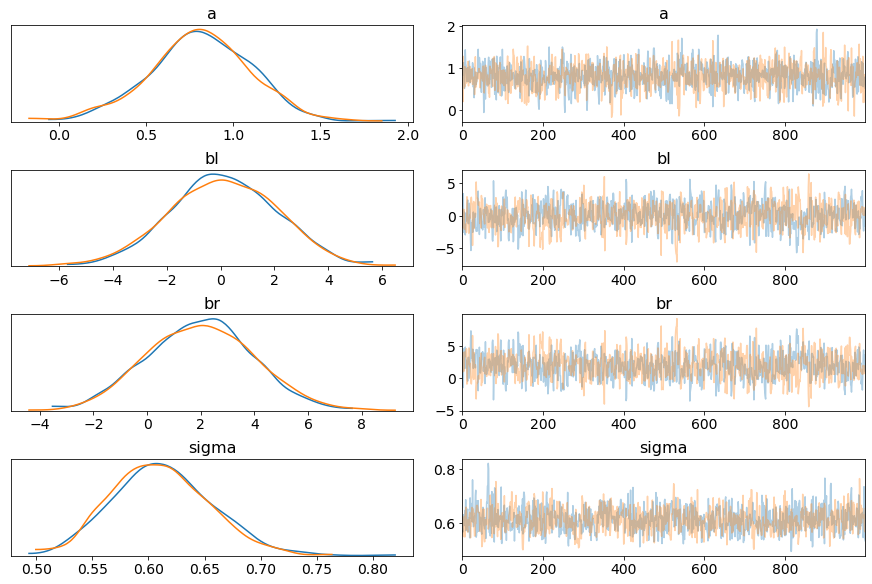

In [5]:
varnames = ['a', 'bl', 'br', 'sigma']
pm.traceplot(trace, varnames)

chain_N = trace[100:]

In [6]:
pm.summary(chain_N, varnames, alpha=.11).round(2)

/home/rer/anaconda3/envs/pymc3_resources/lib/python3.7/site-packages/pymc3/stats.py:982: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  axis=1, join_axes=[dforg.index])


,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
a,0.81,0.29,0.01,0.39,1.31,1317.65,1.0
bl,0.10,1.98,0.07,-3.05,3.27,800.06,1.0
br,1.95,1.98,0.07,-1.16,5.17,795.29,1.0
sigma,0.61,0.04,0.00,0.55,0.68,889.43,1.0


/home/rer/anaconda3/envs/pymc3_resources/lib/python3.7/site-packages/arviz/data/io_pymc3.py:56: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  chain_likelihoods.append(np.stack(log_like))
/home/rer/anaconda3/envs/pymc3_resources/lib/python3.7/site-packages/arviz/plots/forestplot.py:176: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
  ticks.tick1On = False
/home/rer/anaconda3/envs/pymc3_resources/lib/python3.7/site-packages/arviz/plots/forestplot.py:177: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.
  ticks.tick2On = False


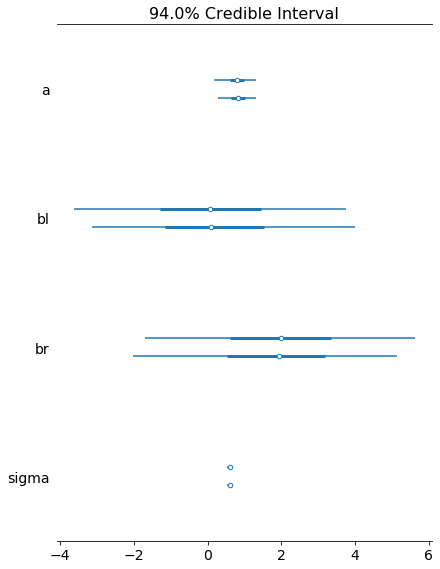

In [7]:
pm.forestplot(chain_N, var_names=varnames);

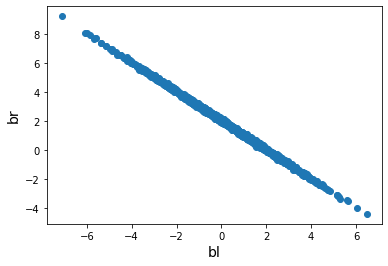

In [8]:
plt.plot(chain_N['bl'], chain_N['br'], 'C0o')
plt.xlabel('bl', fontsize=14)
plt.ylabel('br', fontsize=14);

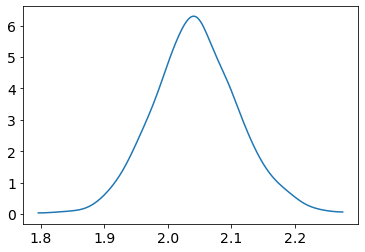

In [9]:
sum_blbr = chain_N['br'] + chain_N['bl']
pm.kdeplot(sum_blbr);

/home/rer/anaconda3/envs/pymc3_resources/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0.5, 1.0, 'Histogram of (bl + br)')

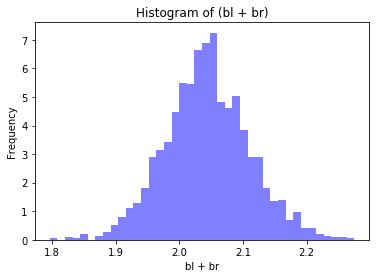

In [10]:
num_bins = 40
# the histogram of the data
n, bins, patches = plt.hist(sum_blbr, num_bins, normed=1, facecolor='blue', alpha=0.5)

plt.xlabel('bl + br')
plt.ylabel('Frequency')
plt.title(r'Histogram of (bl + br)')


In [11]:
with pm.Model() as legHeight:
    a = pm.Normal('a', mu=10, sd=100)
    bl = pm.Normal('bl', mu=2, sd=10)
    sigma = pm.Exponential('sigma', 1)
    mu = pm.Deterministic('mu', a + bl*leg_left)
    height = pm.Normal('height', mu=mu, sd=sigma, observed=d.height)
    trace = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bl, a]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:09<00:00, 422.88draws/s]


/home/rer/anaconda3/envs/pymc3_resources/lib/python3.7/site-packages/arviz/data/io_pymc3.py:56: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  chain_likelihoods.append(np.stack(log_like))


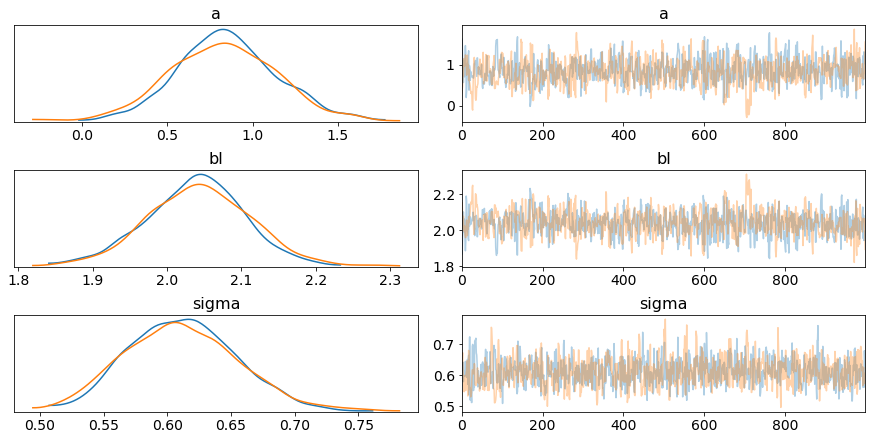

In [12]:
varnames = ['a', 'bl', 'sigma']
pm.traceplot(trace, varnames)

chain_N = trace[100:]

In [13]:
pm.summary(chain_N, varnames, alpha=.11).round(2)

/home/rer/anaconda3/envs/pymc3_resources/lib/python3.7/site-packages/pymc3/stats.py:982: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  axis=1, join_axes=[dforg.index])


,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
a,0.84,0.31,0.01,0.36,1.33,776.88,1.0
bl,2.04,0.07,0.00,1.93,2.14,759.20,1.0
sigma,0.61,0.04,0.00,0.55,0.68,924.02,1.0


/home/rer/anaconda3/envs/pymc3_resources/lib/python3.7/site-packages/pymc3/plots/__init__.py:40: UserWarning: Keyword argument `varnames` renamed to `var_names`, and will be removed in pymc3 3.8
  warnings.warn('Keyword argument `{old}` renamed to `{new}`, and will be removed in pymc3 3.8'.format(old=old, new=new))
/home/rer/anaconda3/envs/pymc3_resources/lib/python3.7/site-packages/arviz/data/io_pymc3.py:56: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  chain_likelihoods.append(np.stack(log_like))
/home/rer/anaconda3/envs/pymc3_resources/lib/python3.7/site-packages/arviz/plots/forestplot.py:176: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
  ticks.tick1On = False
/home/rer/anaconda3/envs/pymc3_resources/lib/pyth

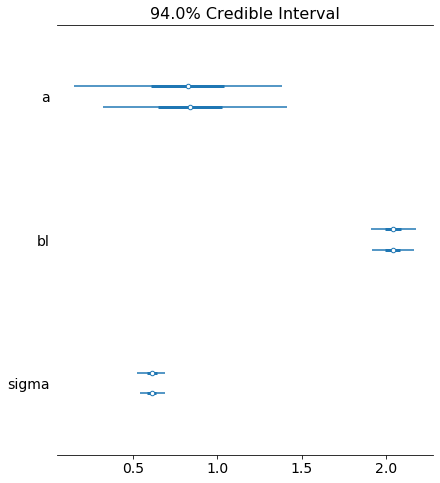

In [14]:
pm.forestplot(chain_N, varnames=varnames);

In [15]:
milk = pd.read_csv('Data/milk.csv', sep=';')

In [16]:
milk.head()

,clade,species,kcal.per.g,perc.fat,perc.protein,perc.lactose,mass,neocortex.perc
0,Strepsirrhine,Eulemur fulvus,0.49,16.60,15.42,67.98,1.95,55.16
1,Strepsirrhine,E macaco,0.51,19.27,16.91,63.82,2.09,NaN
2,Strepsirrhine,E mongoz,0.46,14.11,16.85,69.04,2.51,NaN
3,Strepsirrhine,E rubriventer,0.48,14.91,13.18,71.91,1.62,NaN
4,Strepsirrhine,Lemur catta,0.60,27.28,19.50,53.22,2.19,NaN


In [17]:
scaler = StandardScaler()
milk = milk.reindex( columns = milk.columns.tolist() + ['K','F','L'])
milk[['K','F','L']] = scaler.fit_transform(milk[['kcal.per.g','perc.fat', 'perc.lactose']].to_numpy())

milk.head()

,clade,species,kcal.per.g,perc.fat,perc.protein,perc.lactose,mass,neocortex.perc,K,F,L
0,Strepsirrhine,Eulemur fulvus,0.49,16.60,15.42,67.98,1.95,55.16,-0.956680,-1.238788,1.330401
1,Strepsirrhine,E macaco,0.51,19.27,16.91,63.82,2.09,NaN,-0.830572,-1.048593,1.029186
2,Strepsirrhine,E mongoz,0.46,14.11,16.85,69.04,2.51,NaN,-1.145842,-1.416162,1.407153
3,Strepsirrhine,E rubriventer,0.48,14.91,13.18,71.91,1.62,NaN,-1.019734,-1.359174,1.614963
4,Strepsirrhine,Lemur catta,0.60,27.28,19.50,53.22,2.19,NaN,-0.263087,-0.478006,0.261666


In [18]:
with pm.Model() as Fmodel:
    a = pm.Normal('a',mu=0,sd=0.2)
    bF = pm.Normal('bF',mu=0,sd=0.5)
    sigma = pm.Exponential('sigma',1)
    mu = pm.Deterministic('mu', a + bF * milk.F)
    K = pm.Normal('K', mu=mu, sd=sigma, observed = milk.K)
    trace = pm.sample(10000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bF, a]
Sampling 2 chains: 100%|██████████| 22000/22000 [00:18<00:00, 877.27draws/s] 


/home/rer/anaconda3/envs/pymc3_resources/lib/python3.7/site-packages/arviz/data/io_pymc3.py:56: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  chain_likelihoods.append(np.stack(log_like))


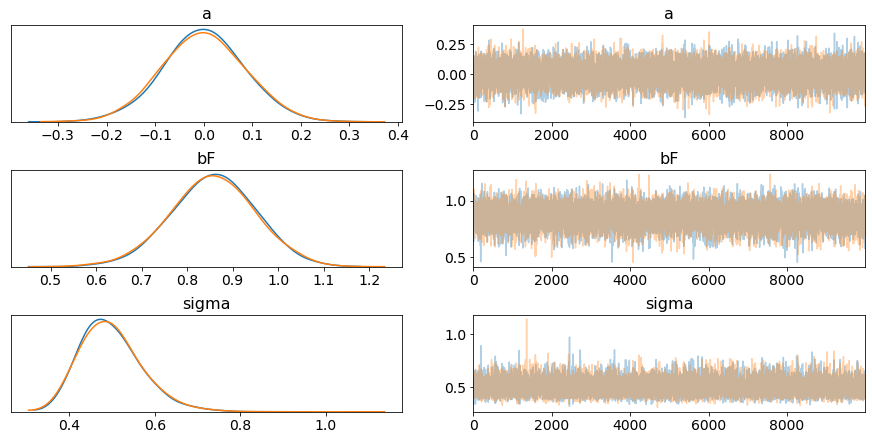

In [19]:
varnames = ['a', 'bF', 'sigma']
pm.traceplot(trace, varnames)

chain_N = trace[1000:]

In [20]:
pm.summary(chain_N, varnames, alpha=.11).round(2)

/home/rer/anaconda3/envs/pymc3_resources/lib/python3.7/site-packages/pymc3/stats.py:982: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  axis=1, join_axes=[dforg.index])


,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
a,0.00,0.08,0.0,-0.13,0.14,26239.67,1.0
bF,0.86,0.09,0.0,0.71,1.01,14705.67,1.0
sigma,0.50,0.07,0.0,0.39,0.60,19114.81,1.0


In [21]:
with pm.Model() as Lmodel:
    a = pm.Normal('a',mu=0,sd=0.2)
    bL = pm.Normal('bL',mu=0,sd=0.5)
    sigma = pm.Exponential('sigma',1)
    mu = pm.Deterministic('mu', a + bL * milk.L)
    K = pm.Normal('K', mu=mu, sd=sigma, observed = milk.K)
    trace = pm.sample(10000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bL, a]
Sampling 2 chains: 100%|██████████| 22000/22000 [00:17<00:00, 1250.81draws/s]


/home/rer/anaconda3/envs/pymc3_resources/lib/python3.7/site-packages/arviz/data/io_pymc3.py:56: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  chain_likelihoods.append(np.stack(log_like))


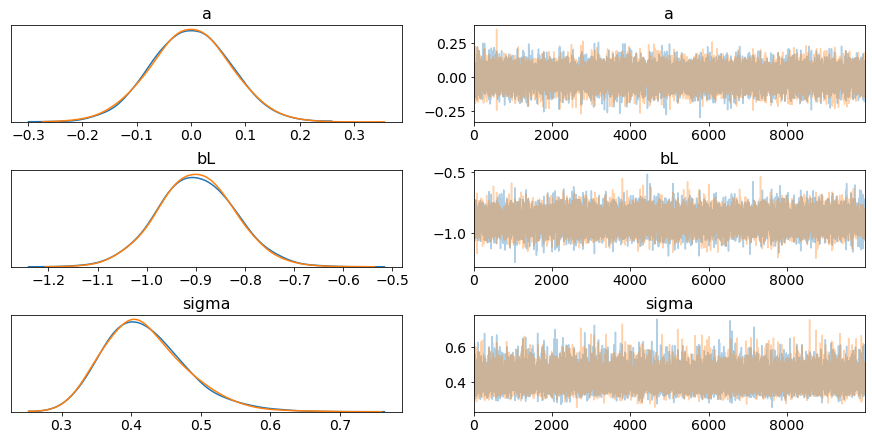

In [22]:
varnames = ['a', 'bL', 'sigma']
pm.traceplot(trace, varnames)

chain_N = trace[1000:]

In [23]:
pm.summary(chain_N, varnames, alpha=.11).round(2)

/home/rer/anaconda3/envs/pymc3_resources/lib/python3.7/site-packages/pymc3/stats.py:982: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  axis=1, join_axes=[dforg.index])


,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
a,-0.00,0.07,0.0,-0.11,0.12,19674.67,1.0
bL,-0.90,0.08,0.0,-1.03,-0.78,22951.16,1.0
sigma,0.42,0.06,0.0,0.33,0.51,18844.67,1.0


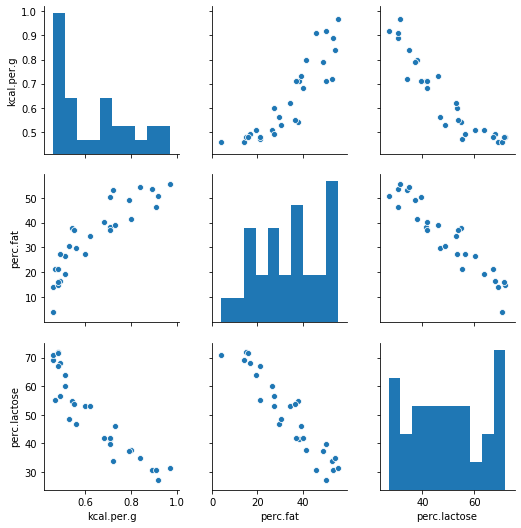

In [24]:
df = milk[['kcal.per.g','perc.fat','perc.lactose']]
sns.pairplot(df);

In [25]:
np.random.seed(seed=896)

with pm.Model() as Lmodel:
    a = pm.Normal('a',mu=0,sd=0.2)
    bF = pm.Normal('bF',mu=0,sd=0.5)
    bL = pm.Normal('bL',mu=0,sd=0.5)
    sigma = pm.Normal('sigma',mu=0,sd=1)
    mu = pm.Deterministic('mu', a + bF * milk.F + bL * milk.L)
    K = pm.Normal('K', mu=mu, sd=sigma, observed = milk.K)
    trace = pm.sample(10000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bL, bF, a]
Sampling 2 chains: 100%|██████████| 22000/22000 [00:30<00:00, 711.58draws/s]


/home/rer/anaconda3/envs/pymc3_resources/lib/python3.7/site-packages/arviz/data/io_pymc3.py:56: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  chain_likelihoods.append(np.stack(log_like))


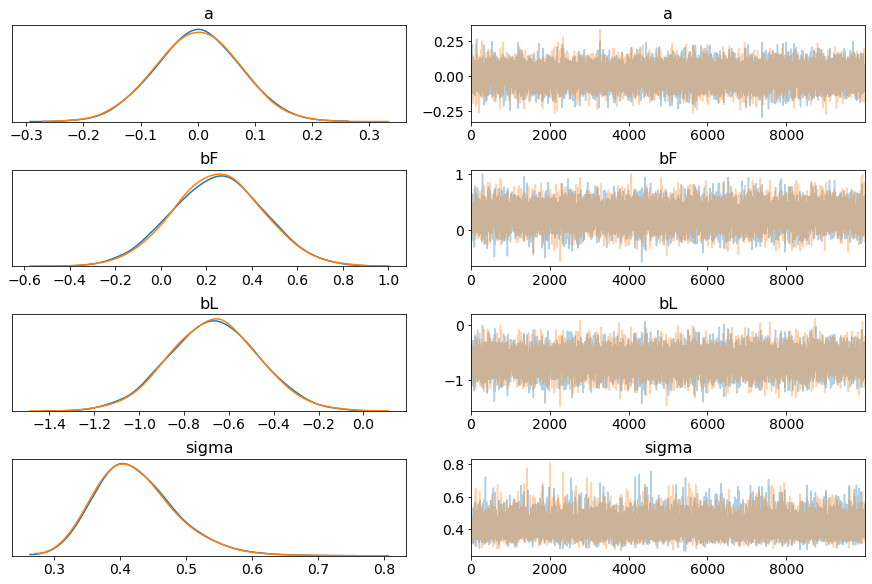

In [26]:
varnames = ['a', 'bF', 'bL', 'sigma']
pm.traceplot(trace, varnames)

chain_N = trace[1000:]

In [27]:
pm.summary(chain_N, varnames, alpha=.11).round(2)

/home/rer/anaconda3/envs/pymc3_resources/lib/python3.7/site-packages/pymc3/stats.py:982: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  axis=1, join_axes=[dforg.index])


,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
a,0.00,0.07,0.0,-0.12,0.11,10934.08,1.0
bF,0.25,0.20,0.0,-0.08,0.56,8036.45,1.0
bL,-0.67,0.20,0.0,-0.98,-0.35,7786.94,1.0
sigma,0.42,0.06,0.0,0.33,0.51,10091.28,1.0


In [28]:
np.corrcoef( milk["perc.fat"] , milk["perc.lactose"] )

array([[ 1.        , -0.94163735],
       [-0.94163735,  1.        ]])

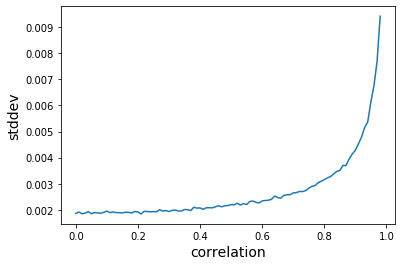

In [29]:
def simcoll(r = 0.9):
    milk['x'] = stats.norm.rvs(size=len(milk), loc = r * milk['perc.fat'],
                       scale = np.sqrt((1 - r**2) * milk['perc.fat'].var()))
    X = np.column_stack((milk['perc.fat'], milk['x']))
    m = smf.OLS(milk['kcal.per.g'], X).fit()
    cov = m.cov_params()
    return (np.diag(cov)[1])**0.5
    
def repsimcoll(r= 0.9, N = 100):
    stddev = [simcoll(r) for _ in range(N)]
    return np.mean(stddev)

lista = []
for i in np.arange(start = 0, stop = 0.99, step = 0.01):   
    lista.append(repsimcoll (r= i, N = 100))

plt.plot(np.arange(start = 0, stop = 0.99, step = 0.01), lista)
plt.xlabel('correlation', fontsize=14)
plt.ylabel('stddev', fontsize=14);

Code 6.14

In [30]:
np.random.seed(seed=71)

# number of plants
N = 100

# simulate initial heights
h0 = stats.norm.rvs(size=N,loc=10,scale=2)

# assign treatments and simulate fungus and growth
treatment = np.repeat( [0,1] , [N/2,N/2] )
fungus = stats.binom.rvs( size=N , loc=0 , n=1, p=0.5 - treatment*0.4 )
h1 = h0 + stats.norm.rvs(size=N, loc=5 - 3*fungus)

# compose a clean data frame
d = pd.DataFrame({'h0': h0,
                  'h1': h1,
                  'Treatment':treatment,
                  'Fungus': fungus})

In [31]:
d.head()

,h0,h1,Treatment,Fungus
0,9.138794,10.180310,0,1
1,7.612144,10.428779,0,1
2,9.111402,14.669235,0,0
3,10.978824,17.013491,0,0
4,9.096886,14.783379,0,0


In [32]:
with pm.Model() as m6_6:
    p = pm.Lognormal('p',mu=0,sd=0.25)
    sigma = pm.Exponential('sigma',1)
    mu = pm.Deterministic('mu', h0 * p)
    h1 = pm.Normal('h1', mu=mu, sd=sigma, observed=d.h1)
    trace = pm.sample(1000, tune=1000)
    
chain = trace[100:]

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, p]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:02<00:00, 1716.19draws/s]


/home/rer/anaconda3/envs/pymc3_resources/lib/python3.7/site-packages/arviz/data/io_pymc3.py:56: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  chain_likelihoods.append(np.stack(log_like))
/home/rer/anaconda3/envs/pymc3_resources/lib/python3.7/site-packages/pymc3/stats.py:982: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  axis=1, join_axes=[dforg.index])


,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
p,1.42,0.02,0.0,1.39,1.45,1967.41,1.0
sigma,1.89,0.14,0.0,1.68,2.11,1883.21,1.0


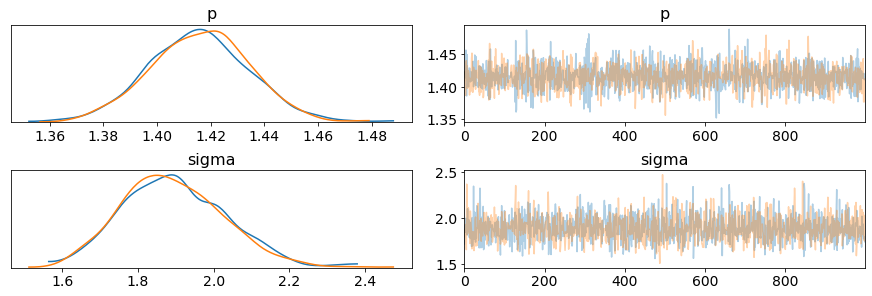

In [33]:
varnames = ['p', 'sigma']
pm.traceplot(trace, varnames)

pm.summary(chain, varnames, alpha=.11).round(2)

In [34]:
pm.summary(chain, varnames, alpha=.11).round(2)

,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
p,1.42,0.02,0.0,1.39,1.45,1967.41,1.0
sigma,1.89,0.14,0.0,1.68,2.11,1883.21,1.0


Code 6.17

In [35]:
with pm.Model() as m6_7:
    a = pm.Lognormal('a',mu=0,sd=0.2)
    bt = pm.Normal('bt', mu=0, sd=0.5)
    bf = pm.Normal('bf', mu=0, sd=0.5)
    sigma = pm.Exponential('sigma',1)
    #p = pm.Deterministic('p', a + bt*d.Treatment + bf*d.Fungus)
    #mu = pm.Deterministic('mu', h0 * p)
    mu = pm.Deterministic('mu', h0 * (a + bt*d.Treatment + bf*d.Fungus))
    h1 = pm.Normal('h1', mu=mu, sd=sigma, observed=d.h1)
    trace = pm.sample(1000, tune=1000)
    
chain = trace[100:]

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bf, bt, a]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:03<00:00, 1103.65draws/s]


/home/rer/anaconda3/envs/pymc3_resources/lib/python3.7/site-packages/arviz/data/io_pymc3.py:56: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  chain_likelihoods.append(np.stack(log_like))
/home/rer/anaconda3/envs/pymc3_resources/lib/python3.7/site-packages/pymc3/stats.py:982: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  axis=1, join_axes=[dforg.index])


,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
a,1.51,0.02,0.0,1.48,1.55,968.41,1.0
bt,-0.02,0.03,0.0,-0.06,0.02,1071.21,1.0
bf,-0.31,0.03,0.0,-0.35,-0.26,1285.06,1.0
sigma,1.26,0.09,0.0,1.11,1.40,1568.60,1.0


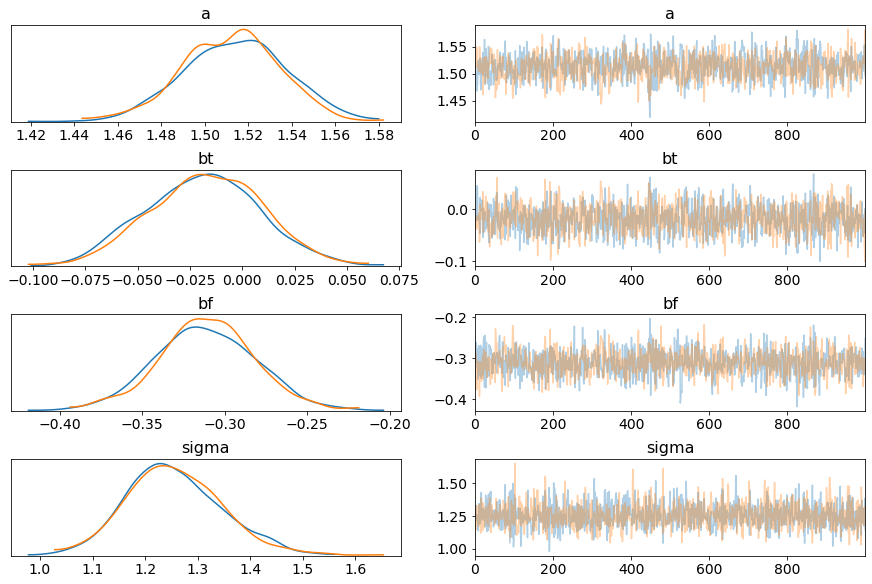

In [36]:
varnames = ['a', 'bt', 'bf', 'sigma']
pm.traceplot(trace, varnames)

pm.summary(chain, varnames, alpha=.11).round(2)

In [37]:
with pm.Model() as m6_7:
    a = pm.Lognormal('a',mu=0,sd=0.2)
    bt = pm.Normal('bt', mu=0, sd=0.5)
    sigma = pm.Exponential('sigma',1)
    mu = pm.Deterministic('mu', h0 * (a + bt*d.Treatment))
    h1 = pm.Normal('h1', mu=mu, sd=sigma, observed=d.h1)
    trace = pm.sample(1000, tune=1000)
    
chain = trace[100:]

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bt, a]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:03<00:00, 1128.92draws/s]


/home/rer/anaconda3/envs/pymc3_resources/lib/python3.7/site-packages/arviz/data/io_pymc3.py:56: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  chain_likelihoods.append(np.stack(log_like))
/home/rer/anaconda3/envs/pymc3_resources/lib/python3.7/site-packages/pymc3/stats.py:982: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  axis=1, join_axes=[dforg.index])


,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
a,1.36,0.03,0.0,1.31,1.40,1249.72,1.0
bt,0.10,0.04,0.0,0.04,0.16,1189.14,1.0
sigma,1.83,0.13,0.0,1.64,2.05,1118.46,1.0


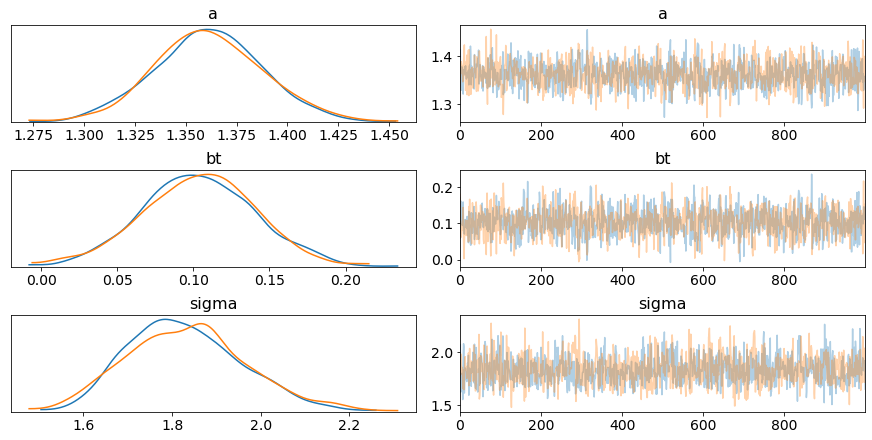

In [38]:
varnames = ['a', 'bt', 'sigma']
pm.traceplot(trace, varnames)

pm.summary(chain, varnames, alpha=.11).round(2)

In [39]:
'''import networkx as nx

G = nx.DiGraph()

# add 5 nodes, labeled 0-4:
map(G.add_node, ['H0', 'T', 'F', 'H1'])

# H1 depends on H0:
G.add_edge('H0','H1')
G.add_edge('F','H1')
G.add_edge('T','F')

# now draw the graph:
pos = { 'H0' : (-1,2), 'T' : (1,2), 'F' : (0.5,1),
        'H1' : (0,0)}
nx.draw(G, pos, labels={'H0': 'H0', 'T':'T', 'F':'F', 'H1':'H1'}, edge_color='r')'''

"import networkx as nx\n\nG = nx.DiGraph()\n\n# add 5 nodes, labeled 0-4:\nmap(G.add_node, ['H0', 'T', 'F', 'H1'])\n\n# H1 depends on H0:\nG.add_edge('H0','H1')\nG.add_edge('F','H1')\nG.add_edge('T','F')\n\n# now draw the graph:\npos = { 'H0' : (-1,2), 'T' : (1,2), 'F' : (0.5,1),\n        'H1' : (0,0)}\nnx.draw(G, pos, labels={'H0': 'H0', 'T':'T', 'F':'F', 'H1':'H1'}, edge_color='r')"

Import dagitty DAG drawing package using rpy2 (note: you need to already have dagitty in your local R libraries, as specified by the lib_loc variable below).  The benefit of doing this is that you can perform statistical inference on the DAG, such as testing for d-separation.  I was unable to find a similar DAG drawing package in Python that also performs stat analysis.

In [40]:
from rpy2.robjects.packages import importr
import rpy2.robjects as ro

importr('dagitty', lib_loc="/home/rer/R/x86_64-pc-linux-gnu-library/3.6")

rpy2.robjects.packages.Package as a <module 'dagitty'>

In [41]:
ro.r('''
        plant_dag <- dagitty( "dag {
        H0 -> H1
        F -> H1
        T -> F
        }")

        coordinates( plant_dag ) <- list( x=c(H0=0,T=2,F=1.5,H1=1) , y=c(H0=0,T=0,F=1,H1=2) ) 

        plot( plant_dag )
        ''')

rpy2.rinterface.NULL

In [42]:
ro.r("on.exit(dev.off())")

rpy2.rinterface.NULL

In [43]:
ro.r('''
    print(dseparated( plant_dag , "T" , "H1" ))
    print(dseparated( plant_dag , "T" , "H1" , "F" ))
    ''')

[1]
 FALSE


[1]
 TRUE




1


In [44]:
ro.r('''
    print(impliedConditionalIndependencies( plant_dag ))
    ''')

F _||_ H0


H0 _||_ T


H1 _||_ T | F




rpy2.rinterface.NULL

In [45]:
ro.r('''
    dag_6.1 <- dagitty( "dag {
    X -> Y <- C
    X <- U -> B
    U <- A -> C
    U -> B <- C
    }")
    adjustmentSets( dag_6.1 , exposure="X" , outcome="Y" )
    ''')

1
'C'
2
'A'
3
'U'


In [46]:
ro.r('''
    dag_6.2 <- dagitty( "dag {
    S -> A -> D
    S -> M -> D
    S -> W -> D
    A -> M
    }")
    adjustmentSets( dag_6.2 , exposure="W" , outcome="D" )
    ''')

R object with classes: ('dagitty.sets',) mapped to:
<ListVector - Python:0x7fc462197e08 / R:0x55cff1076528>
[StrVector, StrVector]
  1: <class 'rpy2.robjects.vectors.StrVector'>
  R object with classes: ('character',) mapped to:
<StrVector - Python:0x7fc463522a08 / R:0x55cff1076668>
['A', 'M']
  2: <class 'rpy2.robjects.vectors.StrVector'>
  R object with classes: ('character',) mapped to:
<StrVector - Python:0x7fc463522a48 / R:0x55cff1b44a00>
['S']

In the output below, X_||_Y | Z, i.e. in the first case, A and W are independent when conditioned on S.

In [47]:
ro.r('''
    impliedConditionalIndependencies( dag_6.2 )
''')

1
X
'A'
Y
'W'
Z
'S'
2
X
'D'
Y
